In [91]:
from matplotlib import pyplot as plt
import platform, os, sys, time
import numpy as np
from tabulate import tabulate
from pprint import pprint
from importlib import reload
from ipywidgets import interact, interact_manual
from scipy.optimize import minimize, fmin_cg, approx_fprime
from numpy.linalg import norm
from numpy import Inf

if 'Windows' in platform.system():
    sys.path.append(r'C:\Users\slab\Documents\Code')
    sys.path.append(r'D:\BEMPP_shared\Modules')
    import interpolate_slow
else:
    sys.path.append("/Users/gkoolstra/Documents/Code")
    from BEMHelper import interpolate_slow
    
from Common import common, kfit
from TrapAnalysis import trap_analysis
from TrapAnalysis import artificial_anneal as anneal
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from scipy.interpolate import interp2d, SmoothBivariateSpline, RectBivariateSpline

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

# Level 2: calculating electron positions using `scipy.minimize` on a FEM obtained potential

In [3]:
save = False
data_path = r"/Users/gkoolstra/Desktop/Electron optimization/Realistic potential/Potentials"


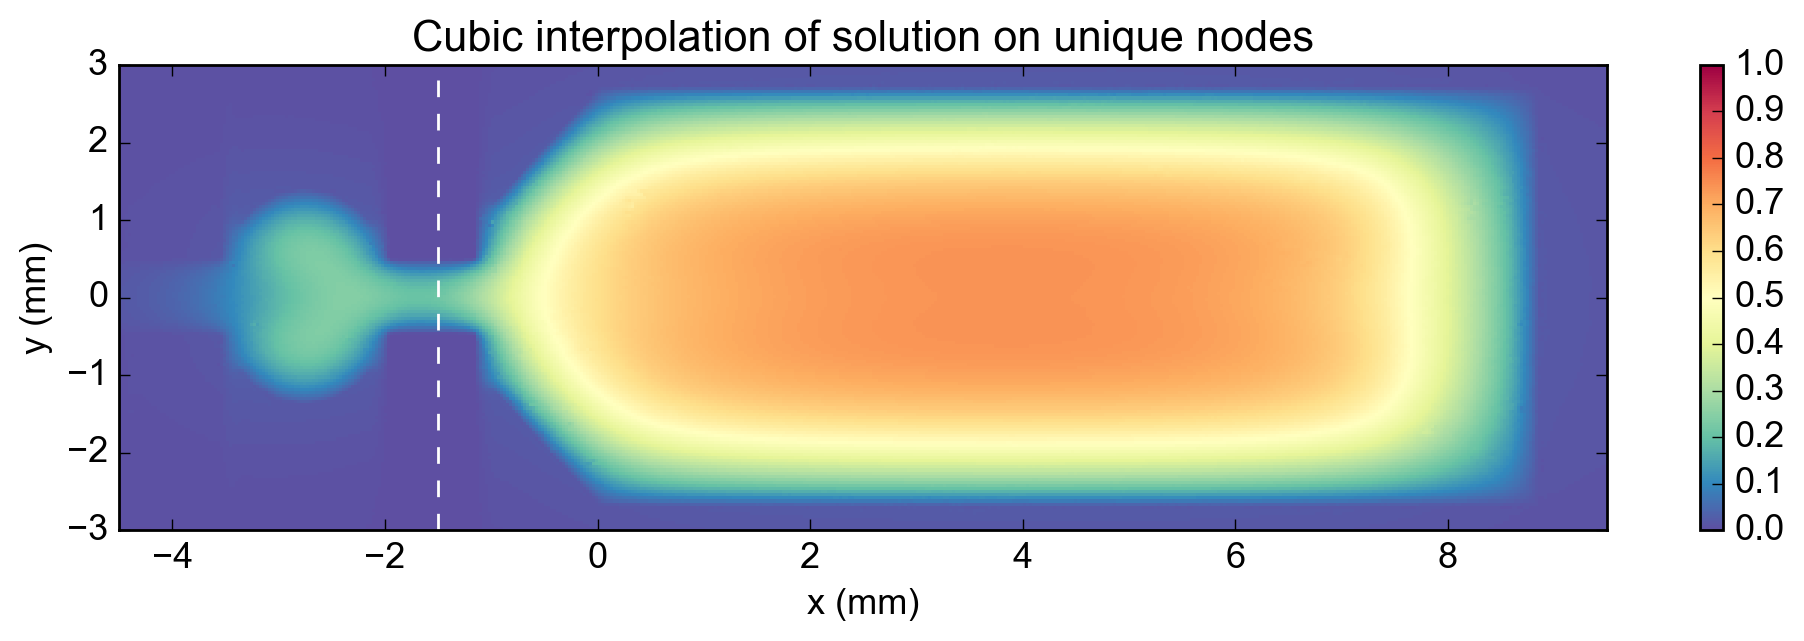

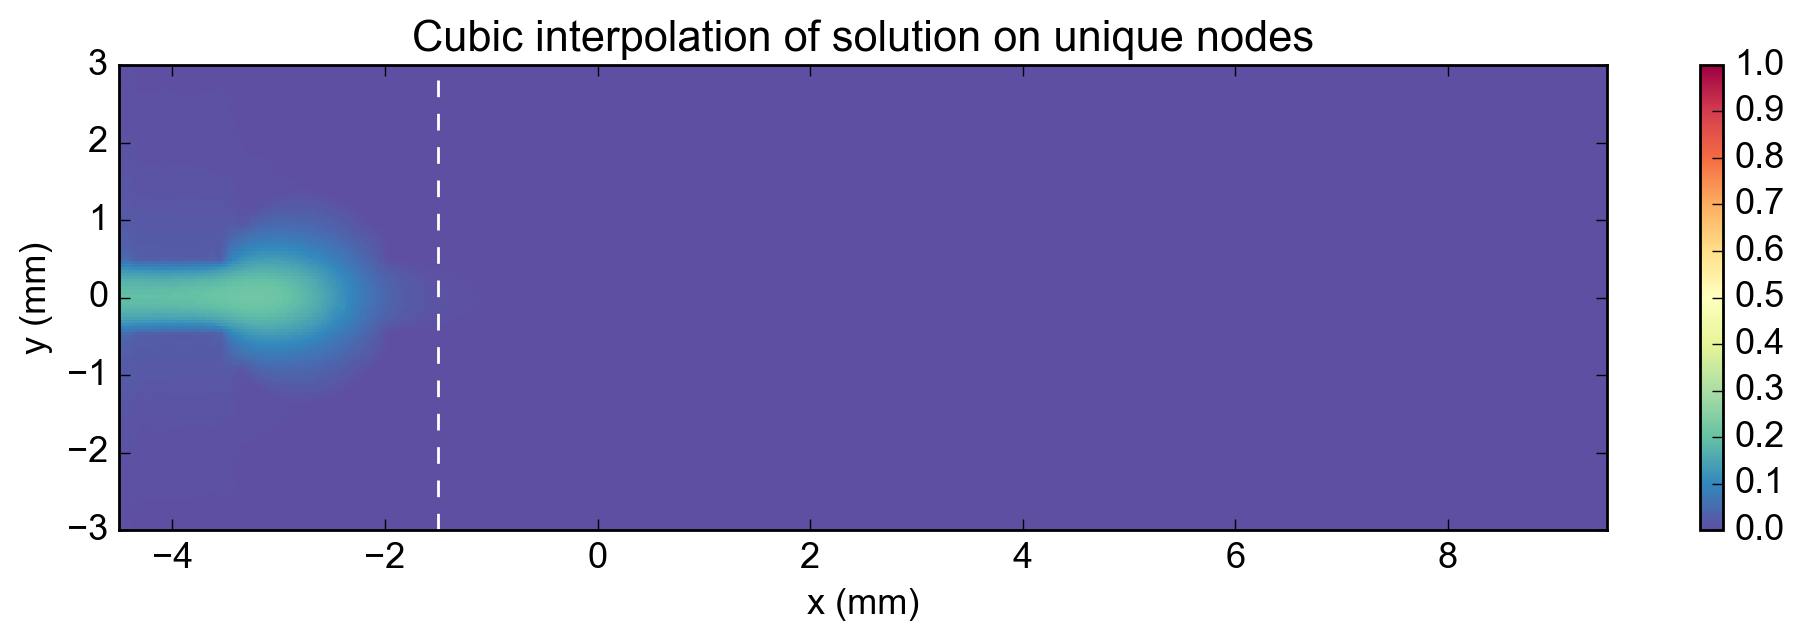

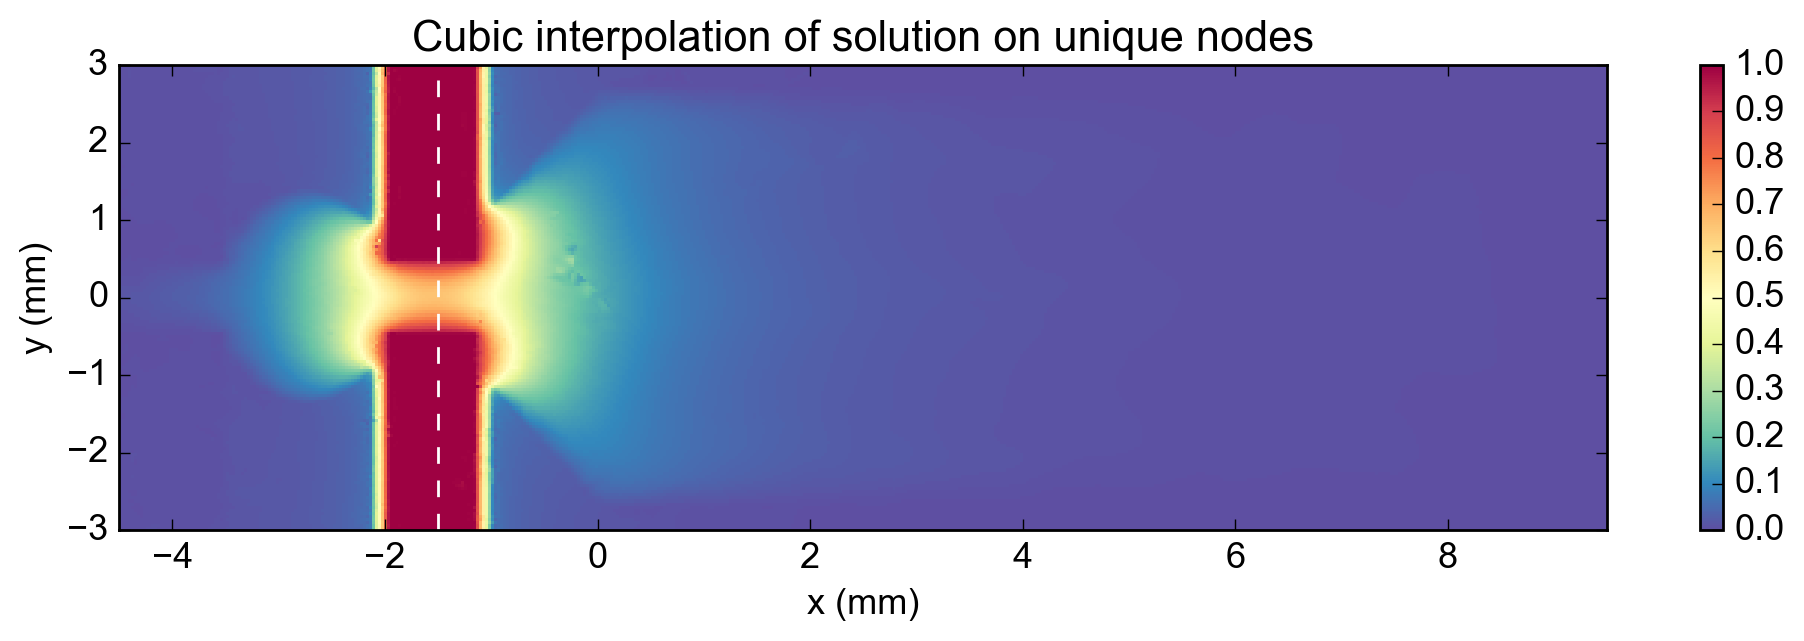

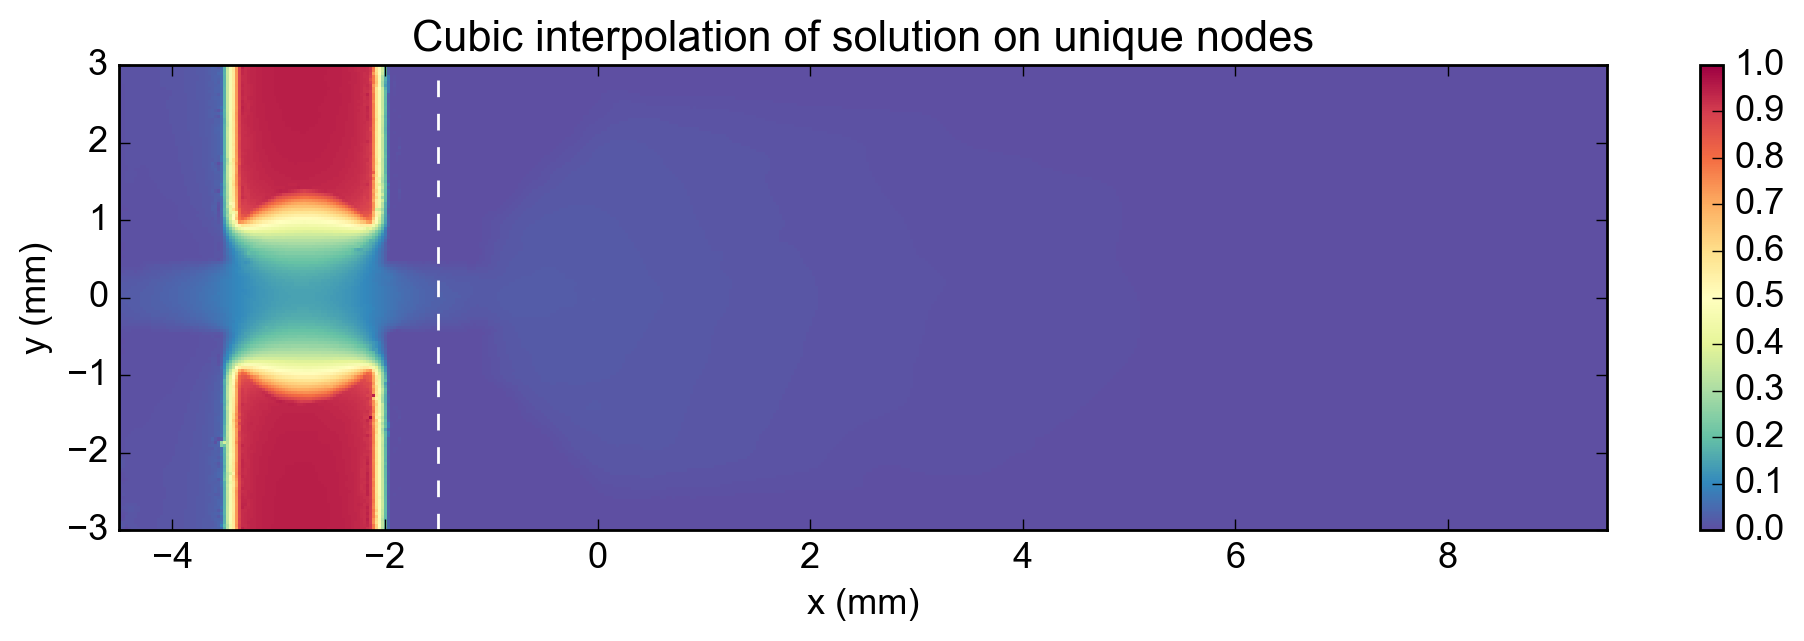

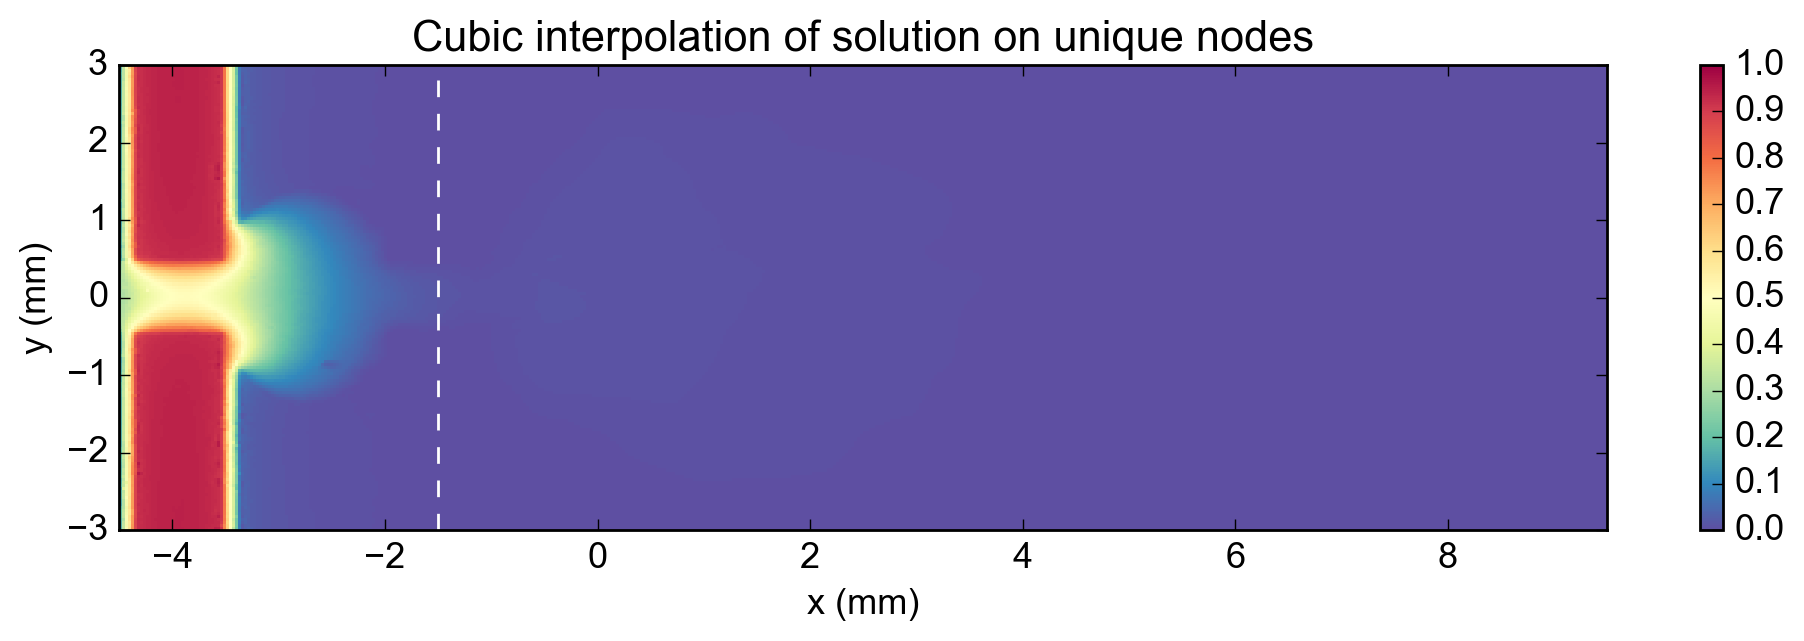

In [4]:
# Evaluate all files in the range
xeval=np.linspace(-4.5, 9.5, 501)
yeval = np.linspace(-3.0, 3.0, 151)

datafiles = [os.path.join(data_path, "Resonator.dsp"),
             os.path.join(data_path, "Trap.dsp"),
             os.path.join(data_path, "ResonatorGuard.dsp"),
             os.path.join(data_path, "CenterGuard.dsp"), 
             os.path.join(data_path, "TrapGuard.dsp")]

output = list()
names = ['resonator', 'trap', 'resonatorguard', 'centerguard', 'trapguard']
for name, datafile in zip(names, datafiles):
    plt.figure(figsize=(12.,3.))
    common.configure_axes(13)
    elements, nodes, elem_solution, bounding_box = trap_analysis.load_dsp(os.path.join(datafile))
    xdata, ydata, Udata = interpolate_slow.prepare_for_interpolation(elements, nodes, elem_solution)
    xcenter = np.mean(bounding_box[0:2])
    ycenter = np.mean(bounding_box[2:4])
    xdata -= xcenter
    ydata -= ycenter
    #interpolate_slow.plot_mesh(os.path.join(datafile))
    xinterp, yinterp, Uinterp = interpolate_slow.plot_BC(xdata, ydata, Udata, xeval=xeval, yeval=yeval, clim=(0, 1.0), 
                                                         plot_axes='xy', cmap=plt.cm.Spectral_r, plot_mesh=False)
    output.append({'name' : name, 'V' : np.array(Uinterp.T, dtype=np.float64),
                               'x' : np.array(xinterp.T, dtype=np.float64), 'y' : np.array(yinterp.T, dtype=np.float64)})
    
    plt.vlines(-1.5, np.min(yeval), np.max(yeval), linestyles="--", color="white")

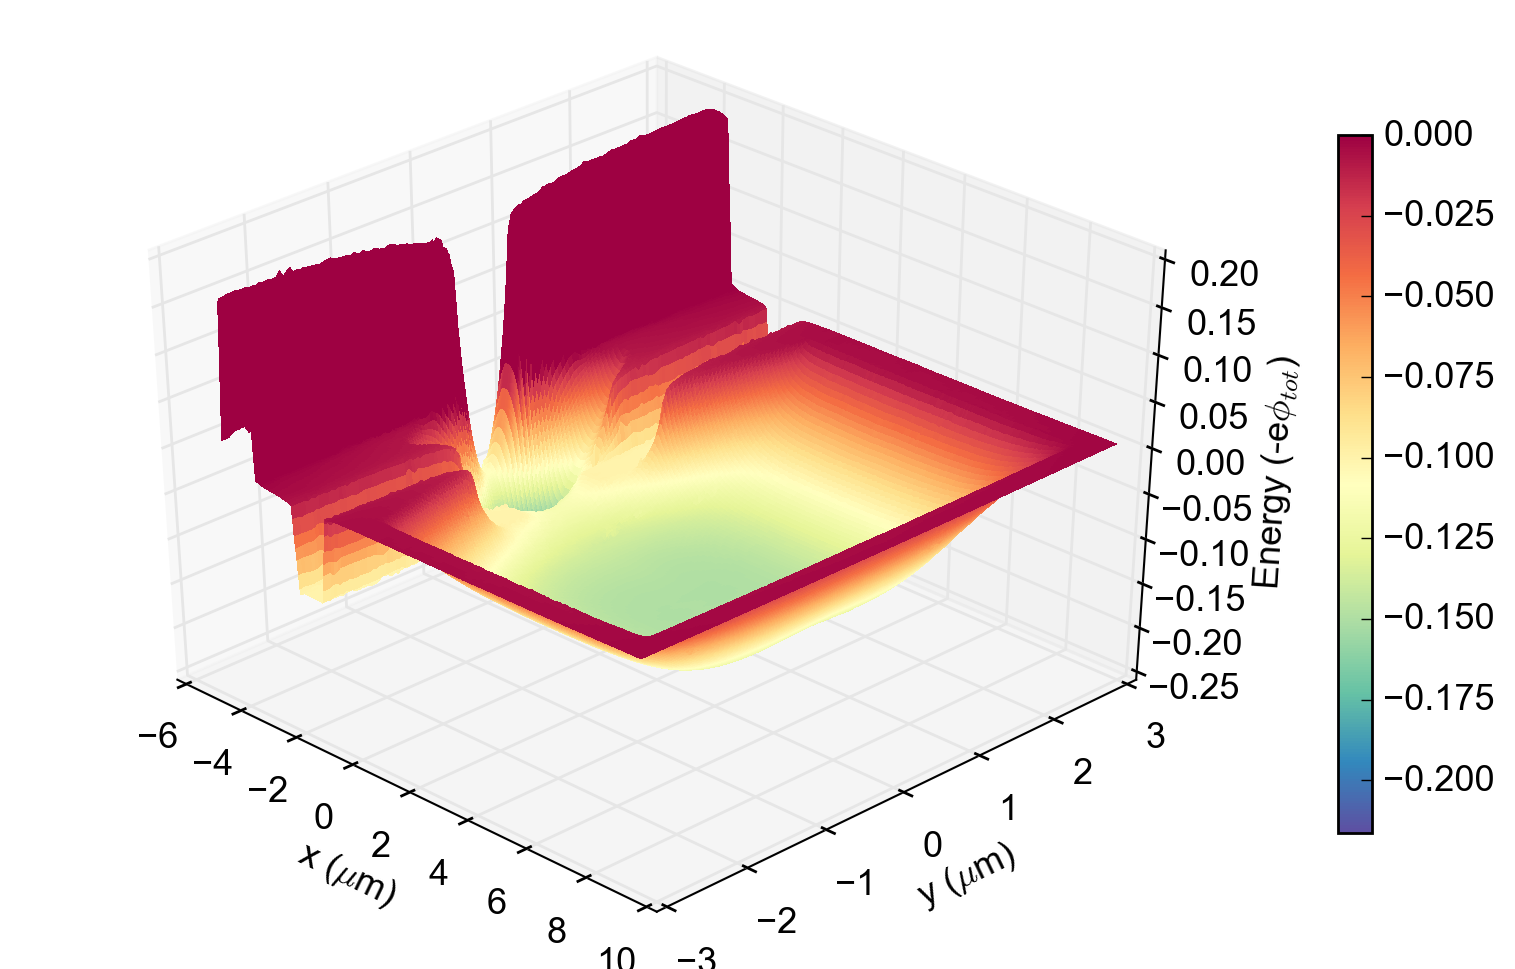

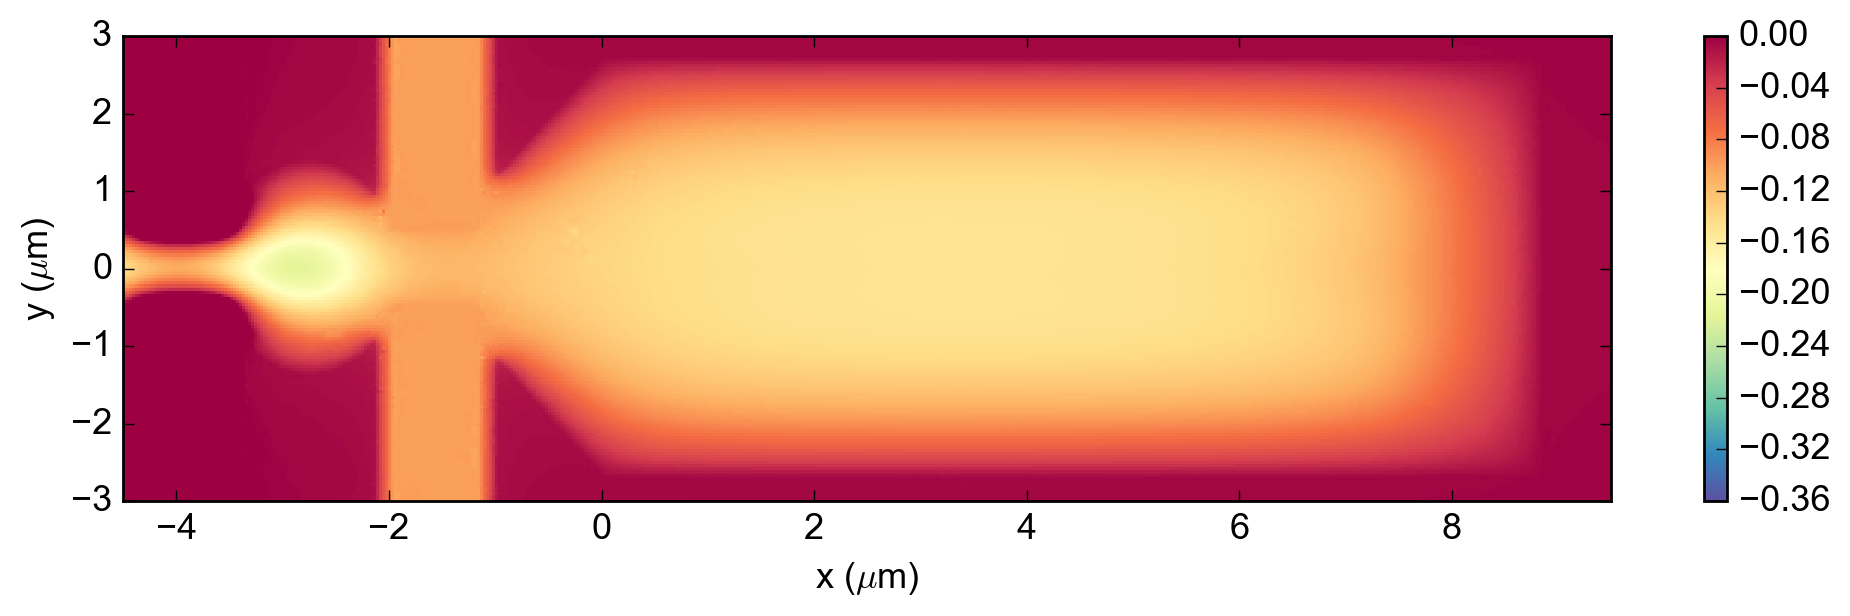

In [5]:
t = trap_analysis.TrapSolver()
c = trap_analysis.get_constants()

Vres = 0.20
Vtrap = 1.00
Vrg = 0.10
Vcg = 0.0
Vtg = -0.20

xeval, yeval, cropped_potentials = t.crop_potentials(output, ydomain=None, xdomain=None)
coefficients = np.array([Vres, Vtrap, Vrg, Vcg, Vtg])
combined_potential = t.get_combined_potential(cropped_potentials, coefficients)

Xm, Ym = np.meshgrid(xeval, yeval)

for view_angle in [-45]:
    fig = plt.figure(figsize=(10.,6.))
    common.configure_axes(13)
    ax = fig.gca(projection='3d')
    surf = ax.plot_surface(Xm, Ym, -combined_potential, rstride=1, cstride=1, cmap=plt.cm.Spectral_r,
                           linewidth=0, antialiased=False, vmax=0.0)
    ax.set_xlabel("x ($\mu$m)")
    ax.set_ylabel("y ($\mu$m)")
    ax.set_zlabel("Energy (-e$\phi_{tot}$)")
    ax.view_init(elev=35., azim=view_angle)
    fig.colorbar(surf, shrink=0.75, aspect=20)  
    
fig = plt.figure(figsize=(12.,3.))
common.configure_axes(13)
plt.pcolormesh(Xm, Ym, -combined_potential, cmap=plt.cm.Spectral_r, vmax=0.0, vmin=-0.36)
plt.xlabel("x ($\mu$m)")
plt.ylabel("y ($\mu$m)")
plt.xlim(np.min(xeval), np.max(xeval))
plt.ylim(np.min(yeval), np.max(yeval))
plt.colorbar()

In [6]:
EP = anneal.ElectrostaticPotential(xeval*1E-6, yeval*1E-6, -combined_potential.T, 
                                   spline_order_x=3, spline_order_y=3, smoothing=0.01)

Verify that the above interpolation function represents the FEM data: 

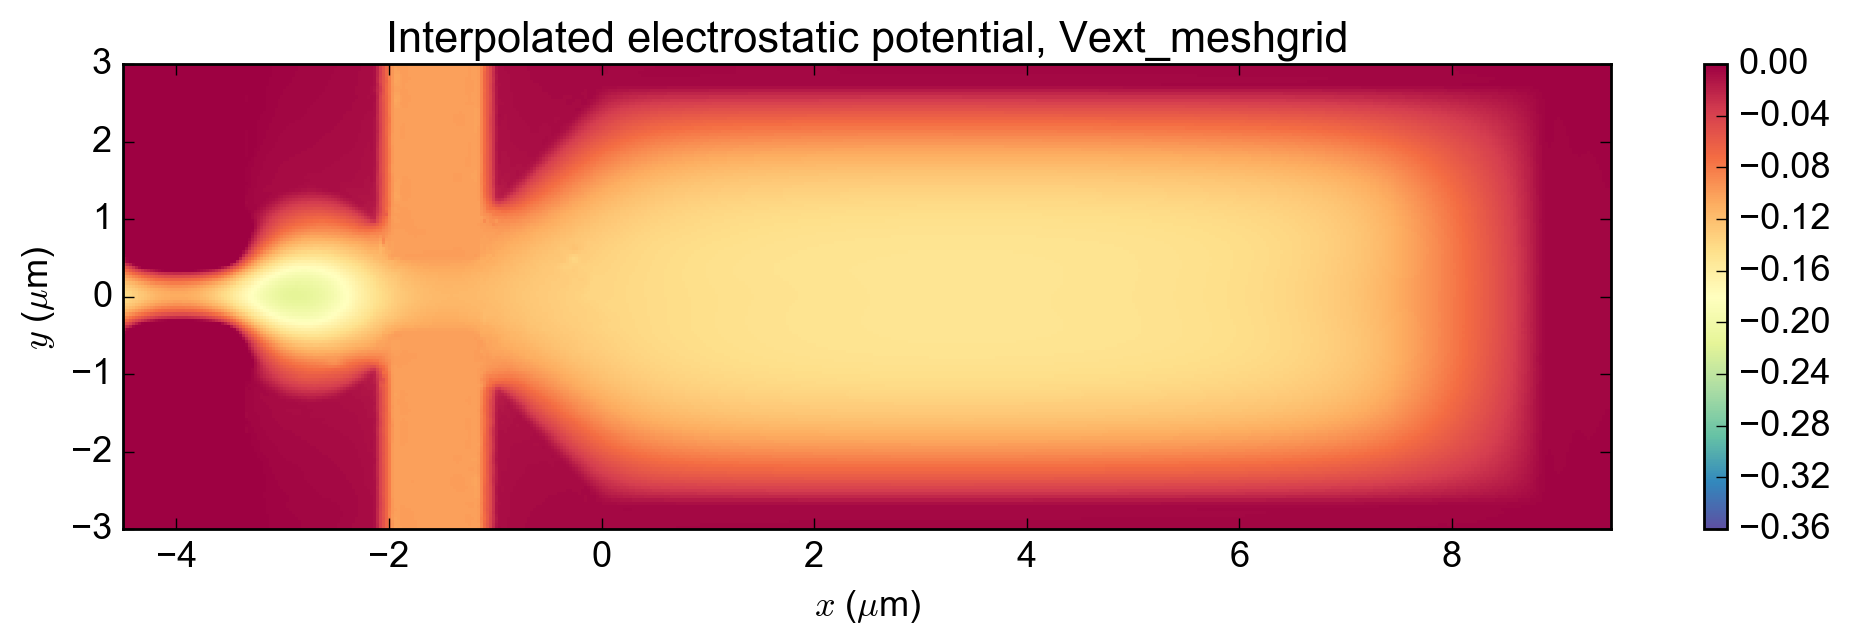

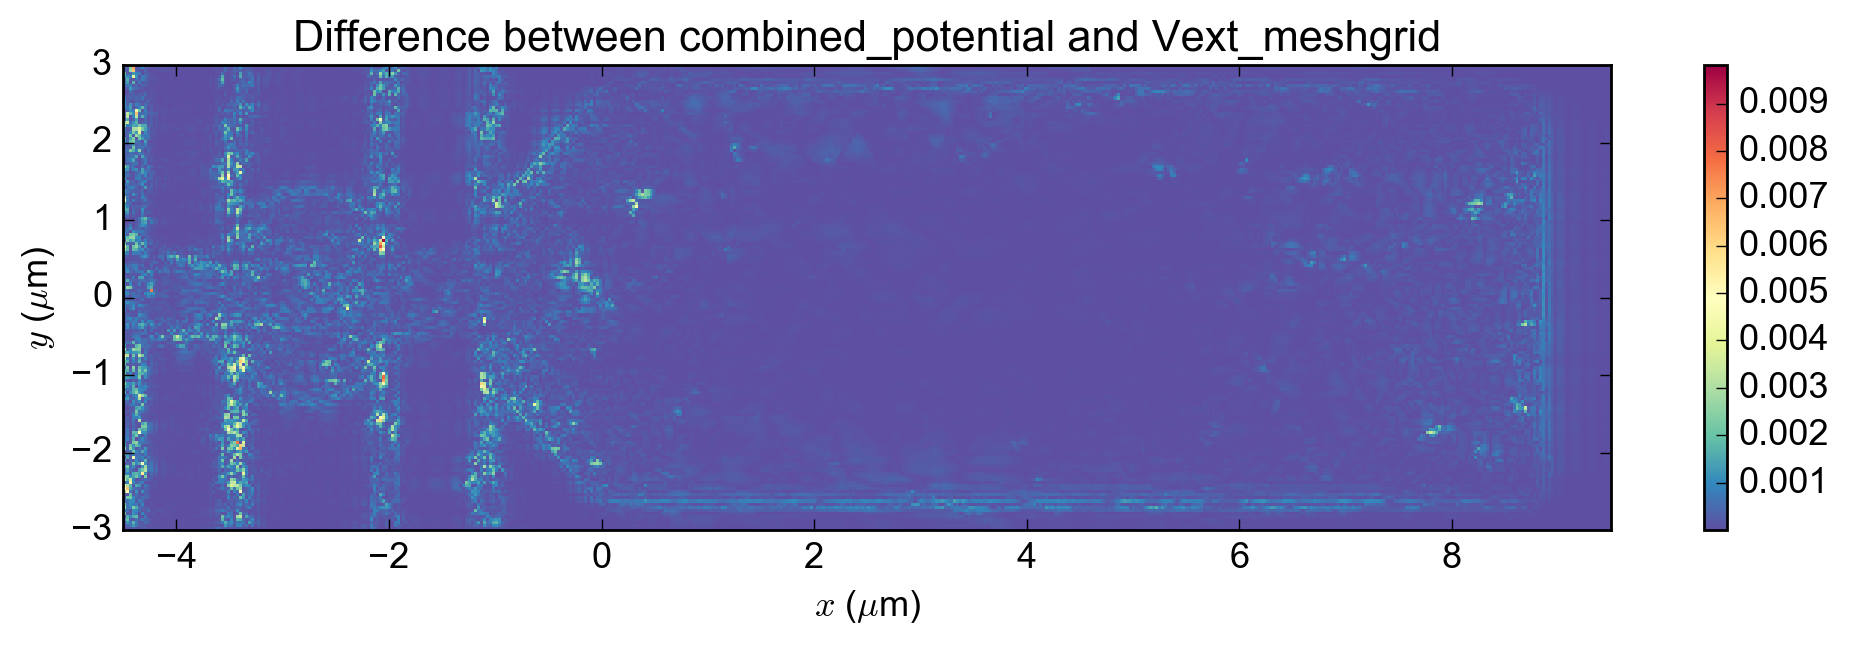

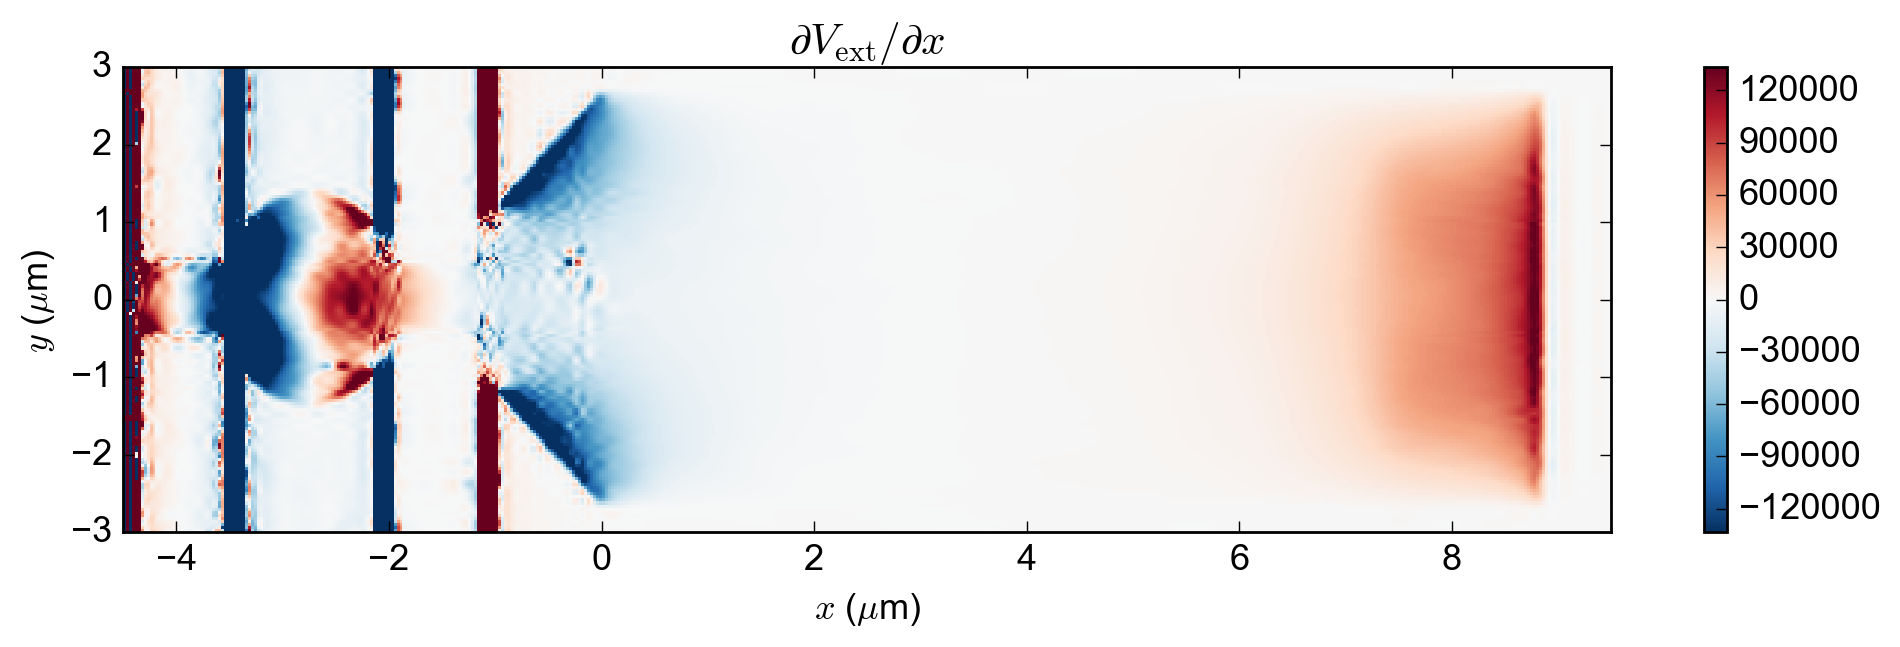

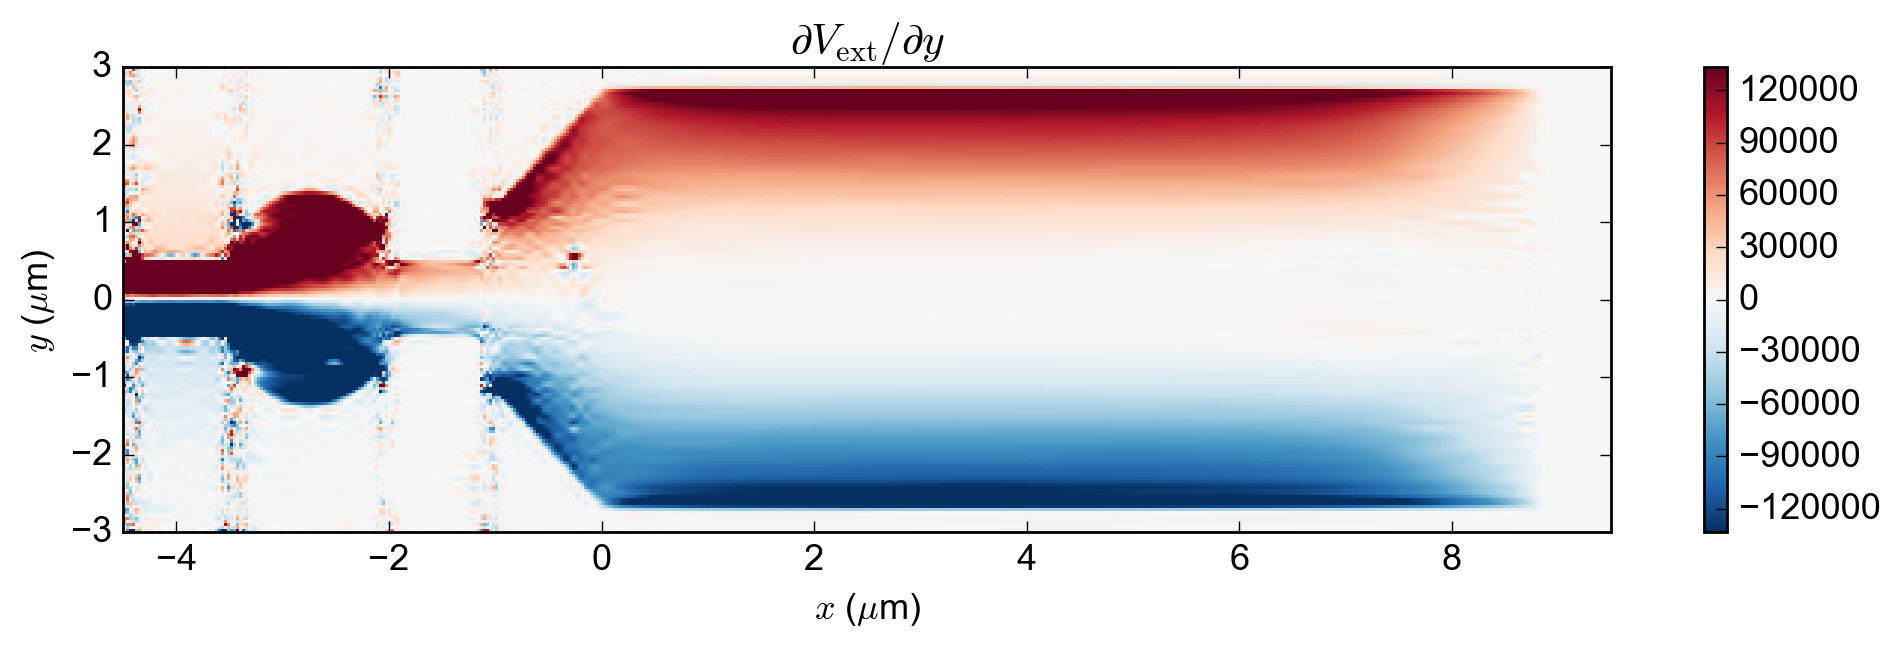

In [7]:
xtest = xeval*1E-6
ytest = yeval*1E-6
Xtest, Ytest = np.meshgrid(xtest, ytest)

plt.figure(figsize=(12.,3.))
plt.pcolormesh(Xtest*1E6, Ytest*1E6, EP.V(Xtest, Ytest), vmax=0.00, vmin=-0.36, cmap=plt.cm.Spectral_r)
plt.colorbar()
plt.xlim(np.min(xtest)*1E6, np.max(xtest)*1E6)
plt.ylim(np.min(ytest)*1E6, np.max(ytest)*1E6)
plt.title("Interpolated electrostatic potential, Vext_meshgrid")
plt.xlabel("$x$ ($\mu$m)")
plt.ylabel("$y$ ($\mu$m)")

if 1:
    plt.figure(figsize=(12.,3.))
    plt.pcolormesh(Xtest*1E6, Ytest*1E6, np.abs(EP.V(Xtest, Ytest)- (-combined_potential)), 
                   cmap=plt.cm.Spectral_r)
    plt.colorbar()
    plt.xlim(np.min(xtest)*1E6, np.max(xtest)*1E6)
    plt.ylim(np.min(ytest)*1E6, np.max(ytest)*1E6)
    plt.title(r"Difference between combined_potential and Vext_meshgrid")
    plt.xlabel("$x$ ($\mu$m)")
plt.ylabel("$y$ ($\mu$m)")

plt.figure(figsize=(12.,3.))
plt.pcolormesh(Xtest*1E6, Ytest*1E6, EP.dVdx(Xtest, Ytest), 
               cmap=plt.cm.RdBu_r, vmin=-1E5*Vres/0.15, vmax=1E5*Vres/0.15)
plt.colorbar()
plt.xlim(np.min(xtest)*1E6, np.max(xtest)*1E6)
plt.ylim(np.min(ytest)*1E6, np.max(ytest)*1E6)
plt.title(r"$\partial V_\mathrm{ext}/\partial x$")
plt.xlabel("$x$ ($\mu$m)")
plt.ylabel("$y$ ($\mu$m)")

plt.figure(figsize=(12.,3.))
plt.pcolormesh(Xtest*1E6, Ytest*1E6, EP.dVdy(Xtest, Ytest), 
               cmap=plt.cm.RdBu_r, vmin=-1E5*Vres/0.15, vmax=1E5*Vres/0.15)
plt.colorbar()
plt.xlim(np.min(xtest)*1E6, np.max(xtest)*1E6)
plt.ylim(np.min(ytest)*1E6, np.max(ytest)*1E6)
plt.title(r"$\partial V_\mathrm{ext}/\partial y$")
plt.xlabel("$x$ ($\mu$m)")
plt.ylabel("$y$ ($\mu$m)")


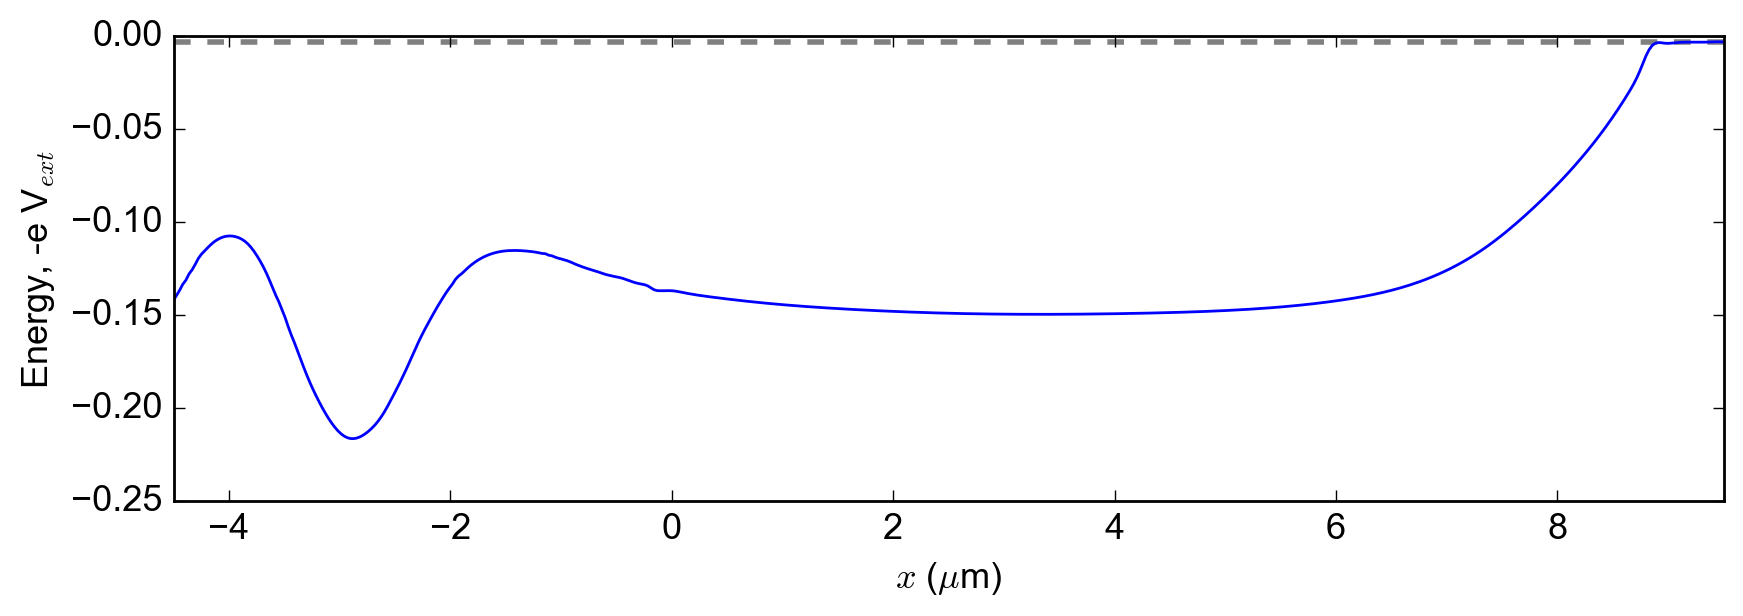

In [8]:
plt.figure(figsize=(10.,3.))
plt.plot(xeval, EP.V(xeval*1E-6, 0E-6))
plt.xlim(np.min(xeval), np.max(xeval))
plt.hlines(EP.V(xeval*1E-6, 0E-6)[-1], np.min(xeval), np.max(xeval), linestyles='--', color='gray', lw=2.0)
plt.xlabel("$x$ ($\mu$m)")
plt.ylabel("Energy, -e V$_{ext}$")

In [9]:
%timeit EP.Velectrostatic(np.array([-2.7E-6, -2.7E-6, -2.7E-6]), np.array([-0.5E-6, 0, 0.5E-6]))

The slowest run took 6.92 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 13.3 µs per loop


Here are the parameters of the simulation. I arrange the electrons in a circle of radius `initial_radius`. The number of electrons can be tweaked by changing `N_electrons`

In [10]:
N_electrons = 50

if 1: 
    # Rectangle
    N_cols = 10
    N_rows = 5
    if N_cols*N_rows != N_electrons:
        raise ValueError("N_cols and N_rows are not compatible with N_electrons")
    else:
        separation = 200E-9
        x0 = 4E-6
        xs = np.linspace(x0, x0+N_cols*separation, N_cols)
        xinit = np.tile(np.array(xs), N_rows)
        ys = np.linspace(-(N_rows-1)/2.*separation, +(N_rows-1)/2.*separation, N_rows)
        yinit = np.repeat(ys, N_cols)
if 0: 
    # Semi-circle
    initial_radius = 2.0E-6
    xinit = xeval[-1]*1E-6 + initial_radius*np.cos(2*np.pi * np.arange(0, N_electrons)/(2*N_electrons) + np.pi/2.)
    yinit = initial_radius*np.sin(2*np.pi * np.arange(0, N_electrons)/(2*N_electrons) + np.pi/2.)
if 0: 
    # Single line parallel to y
    x0 = 1E-6
    initial_span = 3E-6   
    xinit = x0 * np.ones(N_electrons)
    yinit = np.linspace(-initial_span/2., initial_span/2., N_electrons)

electron_initial_positions = anneal.xy2r(xinit, yinit)

# Checks and timing

We can now evaluate the total potential at the initial positions of the electrons. This gives us an idea of the number we see when we start the minimization procedure. Note that the unit is in eV

In [11]:
EP.Vtotal(electron_initial_positions)

-4.50870064096845

This number will always go down when we start the minimization (per definition). Let's find out how fast the function call is for the total energy:

In [12]:
%timeit EP.Vtotal(electron_initial_positions)

The slowest run took 8.51 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 105 µs per loop


And let's find out the value of the $L^\infty$-norm of the gradient before beginning the minimization, and how fast it is: 

In [13]:
print(np.amax(np.abs(EP.grad_total(electron_initial_positions))))
%timeit EP.grad_total(electron_initial_positions)

127875.031981
1000 loops, best of 3: 327 µs per loop


# A single configuration of electrodes

Here is the actual minimization. First we set the matplotlib to Agg to suppress any plots that may come up. For callback we can choose `monitor_convergence` for simply printing the total energy every `N` iterations. We can also choose `save_pictures` to create a movie afterwards. The latter also prints the function value every `N` iterations. 

0	Uopt: -5.70332796 eV	Norm of gradient: 2.49e+04 eV/m
10	Uopt: -6.17743756 eV	Norm of gradient: 7.17e+03 eV/m
20	Uopt: -6.20197056 eV	Norm of gradient: 9.57e+03 eV/m
30	Uopt: -6.20311188 eV	Norm of gradient: 5.40e+03 eV/m
40	Uopt: -6.20379194 eV	Norm of gradient: 1.88e+03 eV/m
50	Uopt: -6.20416151 eV	Norm of gradient: 1.52e+03 eV/m
60	Uopt: -6.20436664 eV	Norm of gradient: 3.75e+03 eV/m
70	Uopt: -6.20458158 eV	Norm of gradient: 3.12e+02 eV/m
80	Uopt: -6.20464604 eV	Norm of gradient: 5.58e+02 eV/m
90	Uopt: -6.20467270 eV	Norm of gradient: 6.11e+02 eV/m
100	Uopt: -6.20467757 eV	Norm of gradient: 2.45e+02 eV/m
110	Uopt: -6.20470166 eV	Norm of gradient: 5.11e+02 eV/m
120	Uopt: -6.20472329 eV	Norm of gradient: 4.27e+02 eV/m
130	Uopt: -6.20477723 eV	Norm of gradient: 1.75e+03 eV/m
140	Uopt: -6.20491025 eV	Norm of gradient: 1.50e+03 eV/m
150	Uopt: -6.20520168 eV	Norm of gradient: 1.19e+03 eV/m
160	Uopt: -6.20524010 eV	Norm of gradient: 1.08e+03 eV/m
170	Uopt: -6.20527447 eV	Norm of gradient:

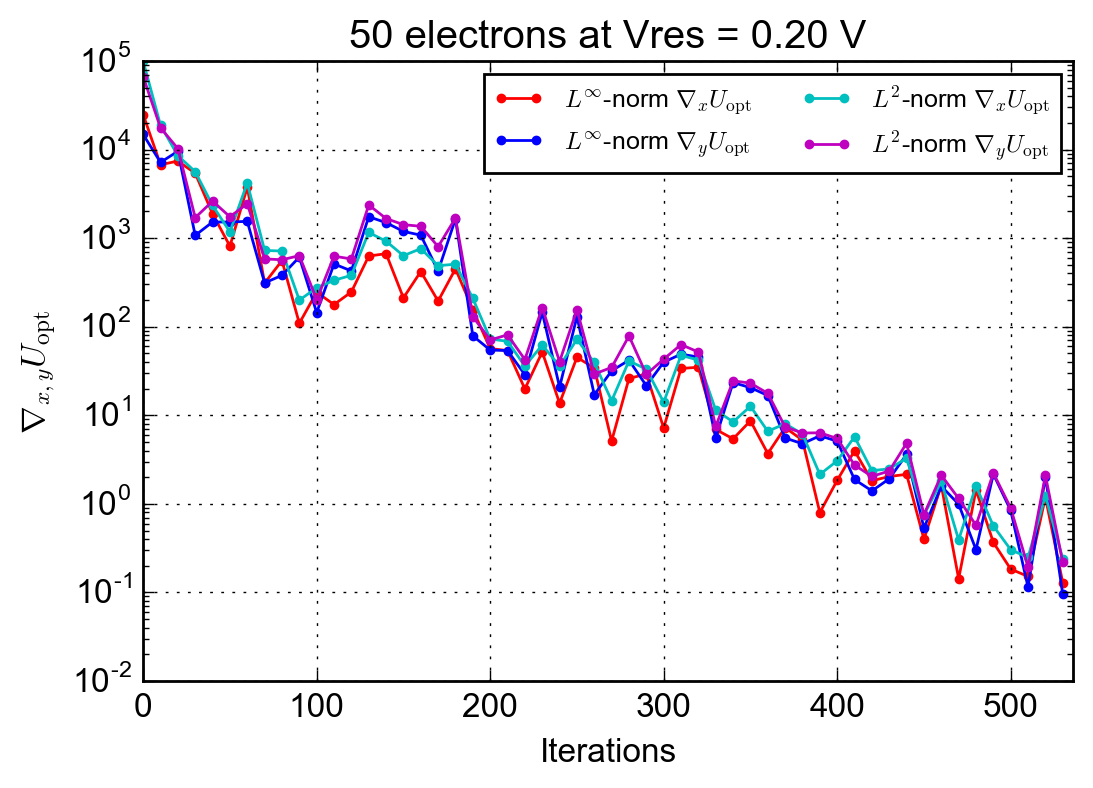

In [14]:
epsilon = 1e-12
use_gradient = True

ConvMon = anneal.ConvergenceMonitor(Uopt=EP.Vtotal, grad_Uopt=EP.grad_total, N=10, Uext=EP.Velectrostatic, 
                                    xext=xeval*1E-6, yext=yeval*1E-6, verbose=True, eps=epsilon, 
                                    save_path=r"/Users/gkoolstra/Desktop/Electron optimization/Realistic potential/Movie")

if use_gradient: 
    jac=EP.grad_total
else:
    jac = None

res = minimize(EP.Vtotal, electron_initial_positions, method='CG', 
               jac=jac, 
               options={'disp': True, 'gtol' : 1E-1}, 
               callback=ConvMon.monitor_convergence)

x, y = anneal.r2xy(res['x'])
final_func_val = res['fun']
n_iterations = res['nit']
    
%matplotlib inline

if len(np.shape(ConvMon.jac))>1:
    figgy = plt.figure(figsize=(6,4))
    common.configure_axes(12)
    # LInf-norm
    plt.plot(ConvMon.iter, np.amax(np.abs(ConvMon.jac[:,::2]), axis=1), 
             '.-r', label=r'$L^\infty$-norm $\nabla_x U_\mathrm{opt}$')
    plt.plot(ConvMon.iter, np.amax(np.abs(ConvMon.jac[:,1::2]), axis=1), 
             '.-b', label=r'$L^\infty$-norm $\nabla_y U_\mathrm{opt}$')
    # L2-norm
    plt.plot(ConvMon.iter, np.sum(np.abs(ConvMon.jac[:,::2])**2.0, axis=1)**(1/2.), 
             '.-c', label=r'$L^2$-norm $\nabla_x U_\mathrm{opt}$')
    plt.plot(ConvMon.iter, np.sum(np.abs(ConvMon.jac[:,1::2])**2.0, axis=1)**(1/2.), 
             '.-m', label=r'$L^2$-norm $\nabla_y U_\mathrm{opt}$')

    plt.title("%d electrons at Vres = %.2f V"%(N_electrons, Vres))
        
    plt.xlabel("Iterations")
    plt.ylabel(r"$\nabla_{x,y} U_\mathrm{opt}$")
    plt.yscale('log')
    plt.xlim(0, res['nit'])
    plt.grid()
    plt.legend(loc=0, ncol=2, prop = {'size' : 9})

In [15]:
if 0:
    ConvMon.create_movie(fps=10)

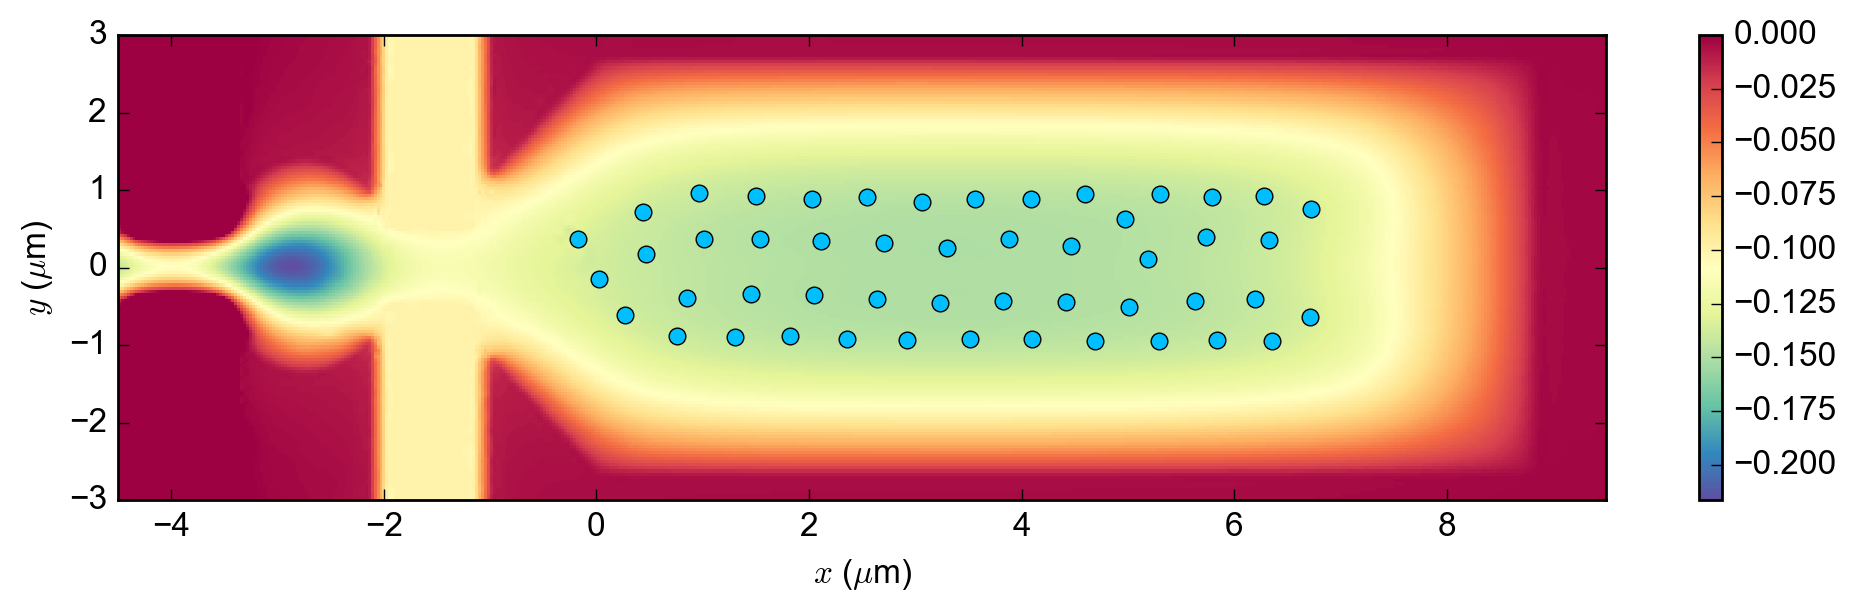

In [16]:
%matplotlib inline

Xinit, Yinit = anneal.map_into_domain(xinit, yinit)
X, Y = anneal.map_into_domain(x, y)
Xeval, Yeval = np.meshgrid(xeval, yeval)

figgy = plt.figure(figsize=(12,3))
common.configure_axes(12)
plt.pcolormesh(xeval, yeval, EP.V(Xeval*1E-6, Yeval*1E-6), cmap=plt.cm.Spectral_r, vmax=0.0)
#plt.plot(x*1E6, y*1E6, 'o', color='deepskyblue')
plt.plot(X*1E6, Y*1E6, 'o', color='deepskyblue')
#plt.plot(xinit*1E6, yinit*1E6, 'o', color='palegreen', alpha=0.5)
#plt.plot(Xinit*1E6, Yinit*1E6, 'o', color='palegreen', alpha=0.5)
# for k, dummy in enumerate(X):
#     plt.text(X[k]*1E6, Y[k]*1E6 + 0.1, str(k+1), fontdict={'color' : 'white', 'size' : 10}, va='bottom', ha='center')

plt.xlim(np.min(xeval), np.max(xeval))
plt.ylim(np.min(yeval), np.max(yeval))
#plt.axes().set_aspect('equal', 'datalim')
plt.xlabel("$x$ ($\mu$m)")
plt.ylabel("$y$ ($\mu$m)")
plt.colorbar()

if save: 
    common.save_figure(figgy, save_path=save_path)

In [17]:
#Calculate the electron density
xi, yi = anneal.r2xy(res['x'])
Xi, Yi = np.meshgrid(xi, yi)
Xj, Yj = Xi.T, Yi.T

Rij = np.sqrt((Xi-Xj)**2 + (Yi-Yj)**2)
np.fill_diagonal(Rij, 1E10)

nearest_neighbors = np.min(Rij, axis=1)
ns = 1/(np.mean(nearest_neighbors))**2 
print("The electron density in the figure above is %.3e m^-2"%ns)

The electron density in the figure above is 3.541e+12 m^-2


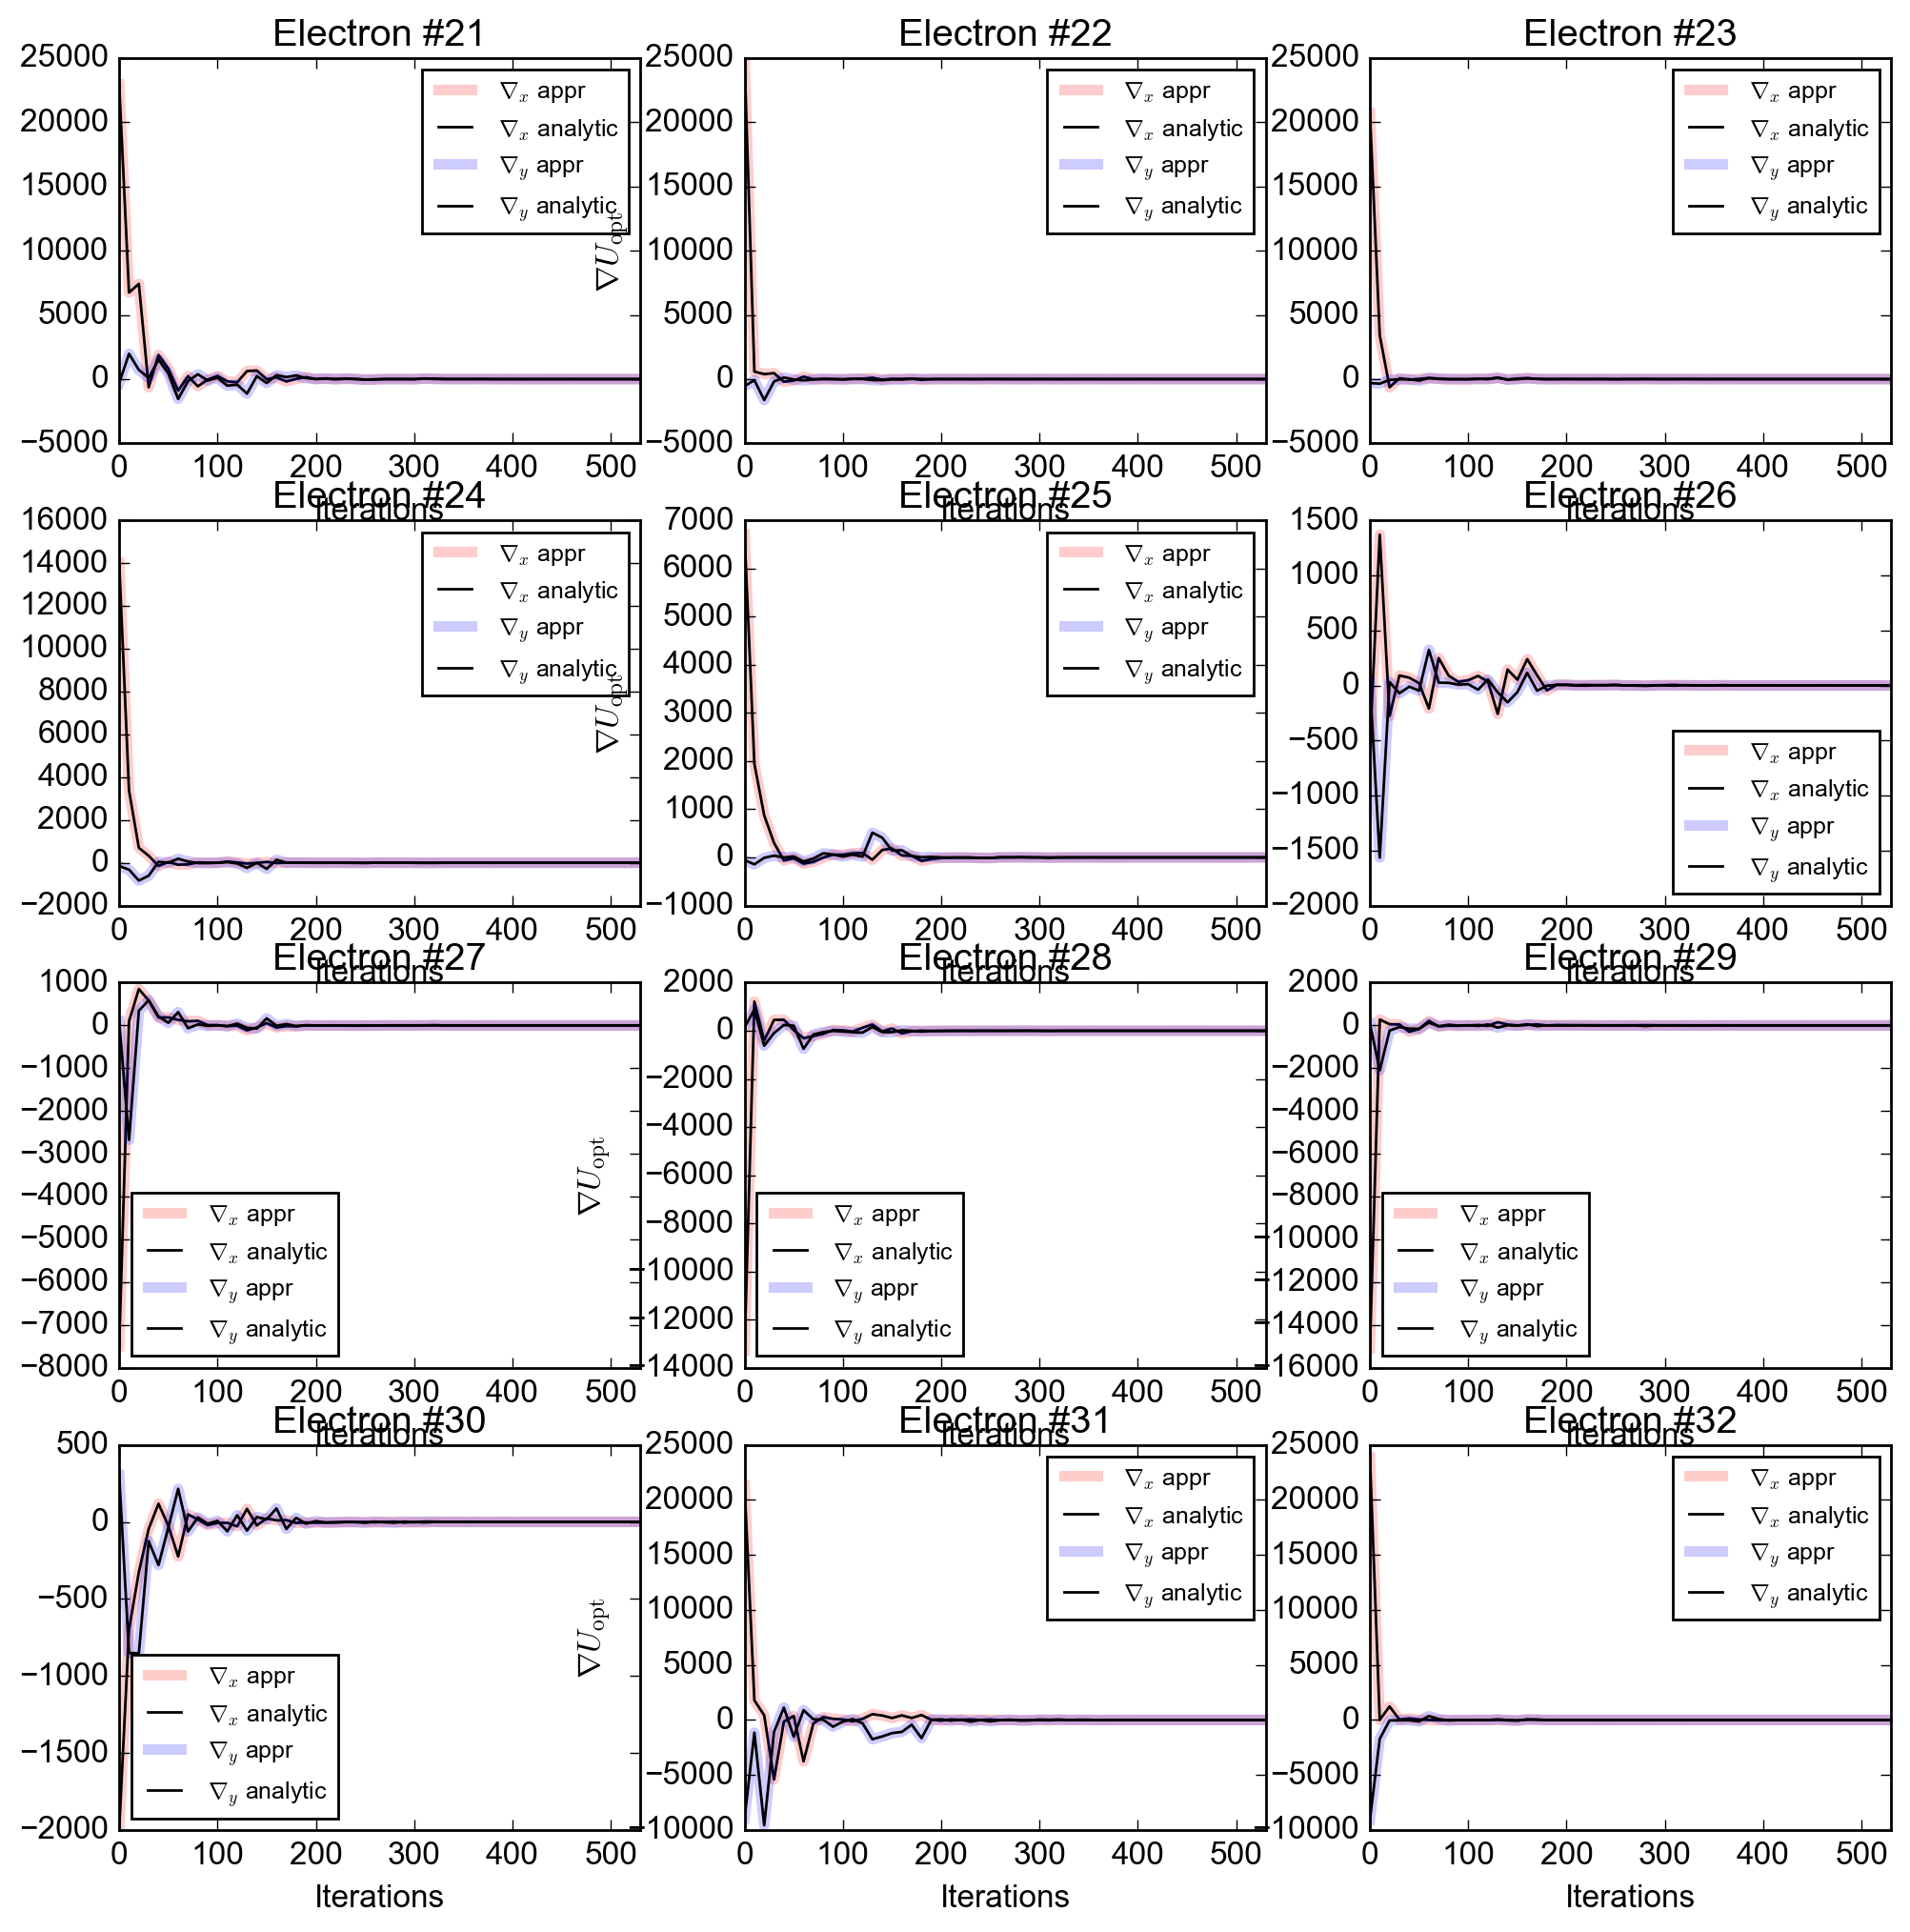

In [18]:
plt.figure(figsize=(12.,12.))

for n in range(20,32,1):
    plt.subplot(4,3,(n+1)-20)
    plt.title("Electron #%d"%(n+1))
    plt.plot(ConvMon.iter, ConvMon.approx_fprime[:,2*n], 'r', 
             alpha=0.2, lw=4.0, label=r'$\nabla_x$ appr')
    plt.plot(ConvMon.iter, ConvMon.jac[:,2*n], 'k', 
             label=r'$\nabla_x$ analytic')
    plt.plot(ConvMon.iter, ConvMon.jac[:,2*n+1], 'b', 
             alpha=0.2, lw=4.0, label=r'$\nabla_y$ appr')
    plt.plot(ConvMon.iter, ConvMon.jac[:,2*n+1], 'k', 
             label=r'$\nabla_y$ analytic')
    #plt.plot(grady_Vext(res['x'][::2], res['x'][1::2])/gc['e'])
    if not n%3:
        plt.ylabel(r"$\nabla U_\mathrm{opt}$")
    if n>=9:
        plt.xlabel('Iterations')
    plt.xlim(0, ConvMon.iter[-1])
    
    plt.legend(loc=0, prop={'size':9})

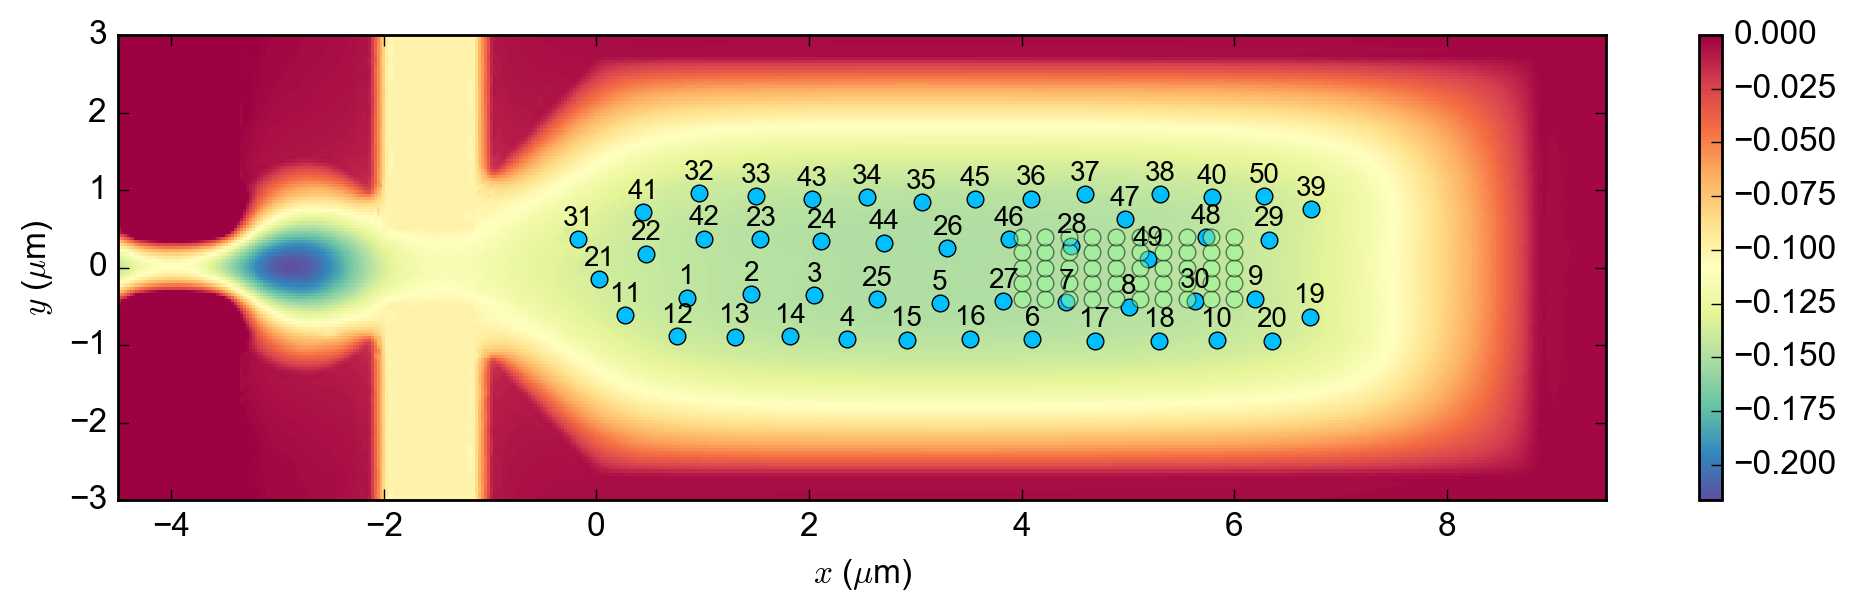

In [19]:
%matplotlib inline

#Xinit, Yinit = map_into_domain(xinit, yinit)
X, Y = anneal.map_into_domain(x, y)
Xeval, Yeval = np.meshgrid(xeval, yeval)

figgy = plt.figure(figsize=(12,3))
common.configure_axes(12)
plt.pcolormesh(xeval, yeval, EP.V(Xeval*1E-6, Yeval*1E-6), cmap=plt.cm.Spectral_r, vmax=0.0)
plt.plot(x*1E6, y*1E6, 'o', color='deepskyblue')
#plt.plot(X*1E6, Y*1E6, 'o', color='deepskyblue')
plt.plot(xinit*1E6, yinit*1E6, 'o', color='palegreen', alpha=0.5)
#plt.plot(Xinit*1E6, Yinit*1E6, 'o', color='palegreen', alpha=0.5)
for k, dummy in enumerate(X):
    plt.text(x[k]*1E6, y[k]*1E6 + 0.1, str(k+1), fontdict={'color' : 'black', 'size' : 10}, va='bottom', ha='center')

plt.xlim(np.min(xeval), np.max(xeval))
plt.ylim(np.min(yeval), np.max(yeval))
#plt.axes().set_aspect('equal', 'datalim')
plt.xlabel("$x$ ($\mu$m)")
plt.ylabel("$y$ ($\mu$m)")
plt.colorbar()

if save:
    common.save_figure(figgy, save_path=save_path)

# Voltage sweep

In [105]:
Vres_sweep = np.linspace(0.12, 0.08, 51)
Vtrap = 1.00
Vrg = 0.05
Vcg = 0.0
Vtg = -0.20

epsilon = 1e-12
use_gradient = True
save_path = r"/Users/gkoolstra/Desktop/Electron optimization/Realistic potential/Voltage sweep"

Start with a rectangular grid. Then for each subsequent voltage point, use the previous solution as initial condition.

In [106]:
N_electrons = 50

# Rectangle
N_cols = 10
N_rows = 5
if N_cols*N_rows != N_electrons:
    raise ValueError("N_cols and N_rows are not compatible with N_electrons")
else:
    separation = 200E-9
    x0 = 4E-6
    xs = np.linspace(x0, x0+N_cols*separation, N_cols)
    xinit = np.tile(np.array(xs), N_rows)
    ys = np.linspace(-(N_rows-1)/2.*separation, +(N_rows-1)/2.*separation, N_rows)
    yinit = np.repeat(ys, N_cols)

electron_initial_positions = anneal.xy2r(xinit, yinit)

In [107]:
electrons_in_trap = list()
reload(anneal)

for k, Vres in enumerate(Vres_sweep):
    print("\nSetting electrode to %.5f V"%Vres)
    
    xeval, yeval, cropped_potentials = t.crop_potentials(output, ydomain=None, xdomain=None)
    coefficients = np.array([Vres, Vtrap, Vrg, Vcg, Vtg])
    combined_potential = t.get_combined_potential(cropped_potentials, coefficients)

    EP = anneal.ElectrostaticPotential(xeval*1E-6, yeval*1E-6, -combined_potential.T, 
                                       spline_order_x=3, spline_order_y=3, smoothing=0.01)

    ConvMon = anneal.ConvergenceMonitor(Uopt=EP.Vtotal, grad_Uopt=EP.grad_total, N=500, Uext=EP.V, 
                                        xext=xeval*1E-6, yext=yeval*1E-6, verbose=True, eps=epsilon, 
                                        save_path=save_path)

    if use_gradient: 
        jac=EP.grad_total
    else:
        jac = None
    
    print("%d\tStarting minimzation routine..."%k)
    
    res = minimize(EP.Vtotal, electron_initial_positions, method='CG', 
                   jac=jac, 
                   options={'disp': False, 'gtol' : 1E-1}, 
                   callback=ConvMon.monitor_convergence)
    
    if res["status"] == 0:
        print("Optimization successful.")
    else:
        raise ValueError("Optimization not converged!")
    
    x, y = anneal.r2xy(res['x'])
    final_func_val = res['fun']
    n_iterations = res['nit']
    
    Xeval, Yeval = np.meshgrid(xeval*1E-6, yeval*1E-6)
    
    save_dict = {"potential_x" : xeval*1E-6,
                 "potential_y" : yeval*1E-6,
                 "potential_V" : EP.V(Xeval, Yeval), 
                 "potential_coefficients" : coefficients,
                 "use_gradient" : use_gradient,
                 "electron_final_coordinates" : res['x'],
                 "electron_initial_coordinates" : electron_initial_positions,
                 "solver_result" : res}
    
    PP = anneal.PostProcess(save_path=save_path)
    PP.save_snapshot(res['x'], xext=xeval*1E-6, yext=yeval*1E-6, Uext=EP.V, figsize=(12.,3.), 
                     clim=(-0.25, 0), common=common)
    PP.write2file(**save_dict)
    
    electrons_in_trap.append(PP.get_trapped_electrons(res['x']))
    
    # Use solution as initial condition for next voltage point
    electron_initial_positions = res['x']


Setting electrode to 0.12000 V
0	Starting minimzation routine...
0	Uopt: -2.83678505 eV	Norm of gradient: 3.27e+04 eV/m
Optimization successful.
Saving file to /Users/gkoolstra/Desktop/Electron optimization/Realistic potential/Voltage sweep/00000.npz ...

Setting electrode to 0.11920 V
1	Starting minimzation routine...
0	Uopt: -3.30023710 eV	Norm of gradient: 9.00e+02 eV/m
Optimization successful.
Saving file to /Users/gkoolstra/Desktop/Electron optimization/Realistic potential/Voltage sweep/00001.npz ...

Setting electrode to 0.11840 V
2	Starting minimzation routine...
0	Uopt: -3.27267463 eV	Norm of gradient: 8.20e+02 eV/m
Optimization successful.
Saving file to /Users/gkoolstra/Desktop/Electron optimization/Realistic potential/Voltage sweep/00002.npz ...

Setting electrode to 0.11760 V
3	Starting minimzation routine...
0	Uopt: -3.24471154 eV	Norm of gradient: 1.35e+03 eV/m
Optimization successful.
Saving file to /Users/gkoolstra/Desktop/Electron optimization/Realistic potential/Volt

ValueError: Optimization not converged!

In [108]:
if 1: 
    ConvMon.create_movie(fps=10, 
                         filenames_in=time.strftime("%Y%m%d")+"_figure_%05d.png", 
                         filename_out="%d_electrons_electrode_sweep.mp4"%(N_electrons))

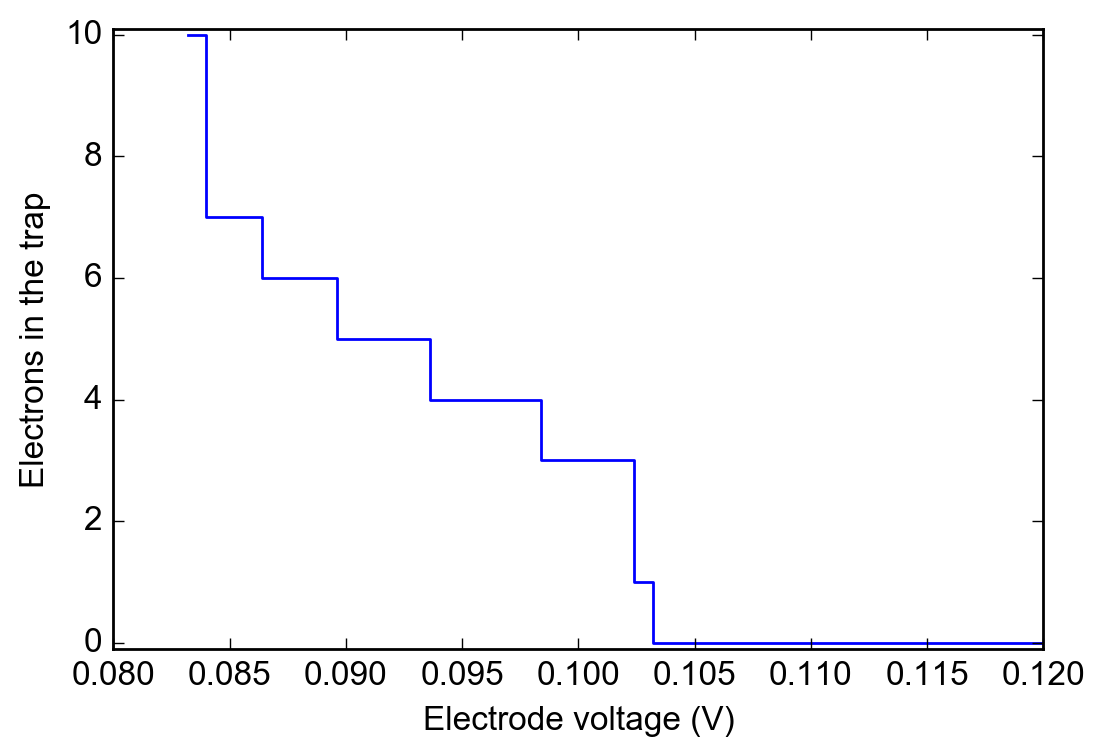

In [109]:
plt.figure(figsize=(6.,4.))
common.configure_axes(12)
plt.step(Vres_sweep[:len(electrons_in_trap)], electrons_in_trap)
plt.ylim((-0.1, np.max(electrons_in_trap)+0.1))
plt.xlim(np.min(Vres_sweep), np.max(Vres_sweep))
plt.ylabel("Electrons in the trap")
plt.xlabel("Electrode voltage (V)")

In [55]:
reload(anneal)

<module 'TrapAnalysis.artificial_anneal' from '/Users/gkoolstra/Documents/Code/TrapAnalysis/artificial_anneal.py'>

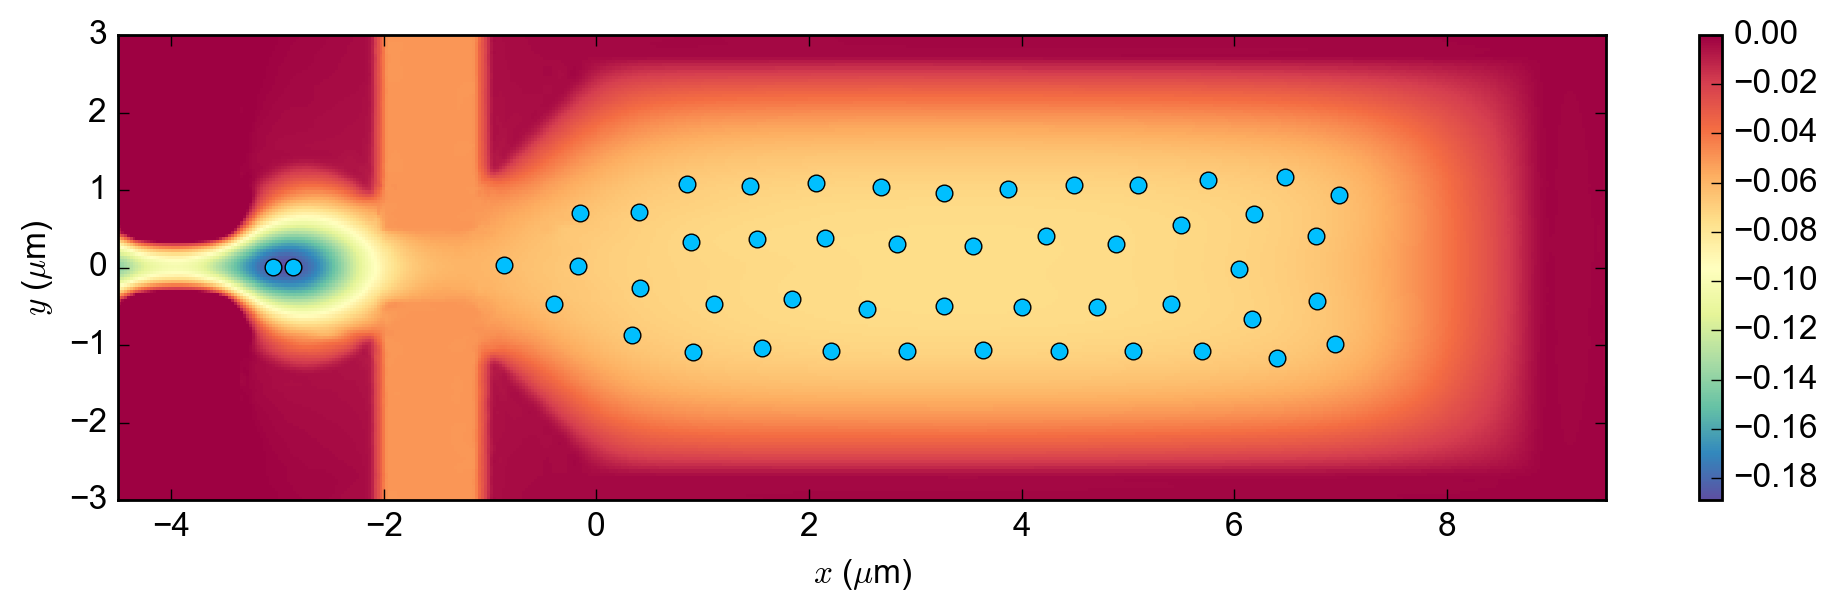

In [78]:
%matplotlib inline

Xinit, Yinit = anneal.map_into_domain(xinit, yinit)
X, Y = anneal.map_into_domain(res['x'][::2], res['x'][1::2])
Xeval, Yeval = np.meshgrid(xeval, yeval)

figgy = plt.figure(figsize=(12,3))
common.configure_axes(12)
plt.pcolormesh(xeval, yeval, EP.V(Xeval*1E-6, Yeval*1E-6), cmap=plt.cm.Spectral_r, vmax=0.0)
plt.plot(X*1E6, Y*1E6, 'o', color='deepskyblue')

plt.xlim(np.min(xeval), np.max(xeval))
plt.ylim(np.min(yeval), np.max(yeval))
plt.xlabel("$x$ ($\mu$m)")
plt.ylabel("$y$ ($\mu$m)")
plt.colorbar()

if save: 
    common.save_figure(figgy, save_path=save_path)